Initial configuration
=====================

In [ ]:
!git clone https://github.com/Dario-Caf/EM-shower-simulator-with-NN
!pip install -r EM-shower-simulator-with-NN/requirements.txt

In [4]:
!nvidia-smi -L
!lscpu |grep 'Model name'

GPU 0: Tesla K80 (UUID: GPU-57b00bb0-af15-cbbd-9819-2fc2d42277cd)
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
%cd EM-shower-simulator-with-NN
%cd EM_shower_simulator
%run debug.py
%run train.py

Imports and costants
====================

In [18]:
import os
import sys
import time
import logging
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras import Model
from tensorflow.keras.utils import Progbar
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.train import CheckpointManager as Manager
from tensorflow.keras.layers import (Input,
                                     Concatenate,
                                     Embedding,
                                     Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv3DTranspose,
                                     MaxPooling3D,
                                     AveragePooling3D,
                                     Conv3D,
                                     Dropout,
                                     Lambda,
                                     ELU,
                                     Flatten)

from IPython import display

from constants import default_list

# Train import
from dataset import logData, data_pull, debug_data_pull, debug_shower

from unbiased_metrics import shower_depth_lateral_width

#-------------------------------------------------------------------------------
"""Constant parameters of configuration and definition of global objects."""

# Configuration parameters
N_PID = 3
N_ENER = 30 + 1
NOISE_DIM = 1024
MBSTD_GROUP_SIZE = 8                                     #minibatch dimension
ENERGY_NORM = 6.7404
ENERGY_SCALE = 1000000.
GEOMETRY = (12, 25, 25, 1)
PARAM_EN = 0.01

# Define logger and handler
logMod = logging.getLogger("ModelsLogger")

# Create a random seed, to be used during the evaluation of the cGAN.
tf.random.set_seed(3)
num_examples = 6
test_noise = [tf.random.normal([num_examples, NOISE_DIM]),
              tf.random.uniform([num_examples, 1], minval= 0., maxval=N_ENER),
              tf.random.uniform([num_examples, 1], minval= 0., maxval=N_PID)]

# Define logger
logGAN = logging.getLogger("CGANLogger")

#-------------------------------------------------------------------------------

VERBOSE = True

# Path list from this folder
path_list = [os.path.join('..', path) for path in default_list]


# Examples to show
EXAMPLES = 5

# Define logger and handler
ch = logging.StreamHandler()
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
ch.setFormatter(formatter)
logger = logging.getLogger("DEBUGLogger")
logger.addHandler(ch)
logData.addHandler(ch)
logMod.addHandler(ch)
logGAN.addHandler(ch)

Make models: tests
==================

In [24]:
"""Subroutins for the creation of the generator and discriminator models."""

#-------------------------------------------------------------------------------
"""General subroutines for the network."""
def compute_energy(in_images):
    """Compute energy deposited in detector."""
    in_images = tf.cast(in_images, tf.float32)
    en_images = tf.math.multiply(in_images, ENERGY_NORM)
    en_images = tf.math.pow(10., en_images)
    en_images = tf.math.divide(en_images, ENERGY_SCALE)
    en_images = tf.math.reduce_sum(en_images, axis=[1,2,3])
    return en_images

#-------------------------------------------------------------------------------
"""Subroutines for the generator network."""

def make_generator_model():
    """Define generator model:
    Input 1) Random noise from which the network creates a vector of images;
    Input 2) Energy label to be passed to the network;
    Input 3) ParticleID label to be passed to the network.

    Labels are given as scalars in input; then they are passed to an embedding
    layer that creates a sort of lookup-table (vector[EMBED_DIM] of floats) that
    categorizes the labels in N_CLASSES * classes.
    """
    BASE = 8
    FILTER = 32
    EMBED_DIM = 30
    KERNEL_L = (1, 8, 8)
    KERNEL_S = (3, 6, 6)
    n_nodes = BASE*BASE*BASE
    image_shape = (BASE, BASE, BASE, -1)

    # Input[i] -> input[i] + convolution * (KERNEL-1)
    error = "ERROR building the generator: shape different from geometry!"

    # Image generator input
    in_lat = Input(shape=(NOISE_DIM,), name="latent_input")
    li_lat = Reshape(image_shape)(in_lat)

    # Energy label input
    en_label = Input(shape=(1,), name="energy_input")
    li_en = Dense(2*FILTER, activation="relu")(en_label)
    li_en = Dense(n_nodes, activation="relu")(li_en)
    li_en = Reshape(image_shape)(li_en)

    # ParticleID label input
    pid_label = Input(shape=(1,), name="particle_input")
    li_pid = Embedding(N_PID, EMBED_DIM)(pid_label)
    li_pid = Dense(n_nodes, activation="relu")(li_pid)
    li_pid = Reshape(image_shape)(li_pid)

    # Combine noise and particle ID
    gen = Concatenate()([li_lat, li_pid])
    logMod.info(gen.get_shape())

    gen = Conv3DTranspose(3, KERNEL_S, padding="same", use_bias=False)(gen)
    logMod.info(gen.get_shape())
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    # Combine image and energy
    gen = Concatenate()([gen, li_en])
    logMod.info(gen.get_shape())

    gen = Conv3DTranspose(FILTER, KERNEL_L, use_bias=False)(gen)
    logMod.info(gen.get_shape())
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.1)(gen)

    gen = Conv3DTranspose(FILTER, KERNEL_S, use_bias=False)(gen)
    logMod.info(gen.get_shape())
    # gen = BatchNormalization()(gen)
    gen = LeakyReLU(alpha=0.1)(gen)

    output = Conv3DTranspose(1, KERNEL_S, activation="tanh", use_bias=False,
                                                              name="image")(gen)
    # output = ELU(name="filtered_image")(output)

    logMod.info(f"Shape of the generator output: {output.get_shape()}")
    assert output.get_shape().as_list()==[None, *GEOMETRY], error

    model = Model([in_lat, en_label, pid_label], output, name='generator')
    return model

def debug_generator(noise, verbose=False):
    """Uses the random seeds to generate fake samples and plots them."""
    if verbose :
        logMod.setLevel(logging.DEBUG)
        logMod.info('Logging level set on DEBUG.')
    else:
        logMod.setLevel(logging.WARNING)
        logMod.info('Logging level set on WARNING.')
    logMod.info("Start debugging the generator model.")

    generator = make_generator_model()
    data_images = generator(noise, training=False)
    logMod.info(f"Shape of generated images: {data_images.shape}")

    energy = compute_energy(data_images)

    k=0
    plt.figure("Generated showers", figsize=(20,10))
    num_examples = data_images.shape[0]
    for i in range(num_examples):
        print(f"{i+1})\tPrimary particle={int(noise[2][i][0])}"
             +f"\tInitial energy ={noise[1][i][0]}"
             +f"\tGenerated energy ={energy[i]}\n")
        for j in range(data_images.shape[1]):
           k=k+1
           plt.subplot(num_examples, data_images.shape[1], k)
           plt.imshow(data_images[i,j,:,:,0])
           plt.axis("off")
    plt.show()

    logMod.info("Debug of the generator model finished.")

#-------------------------------------------------------------------------------
"""Subroutines for the discriminator network."""

def minibatch_stddev_layer(discr, group_size=MBSTD_GROUP_SIZE):
    """Minibatch discrimination layer is important to avoid mode collapse.
    Once it is wrapped with a Lambda Keras layer it returns an additional filter
    node with information about the statistical distribution of the group_size,
    allowing the discriminator to recognize when the generator strarts to
    replicate the same kind of event multiple times.

    Inspired by
    https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py
    """
    with tf.compat.v1.variable_scope('MinibatchStddev'):
        # Input 0 dimension must be divisible by (or smaller than) group_size.
        group_size = tf.minimum(group_size, tf.shape(discr)[0])
        # Input shape.
        shape = discr.shape
        # Split minibatch into M groups of size G.
        minib = tf.reshape(discr, [group_size, -1, shape[1], shape[2], shape[3], shape[4]])
        # Cast to FP32.
        minib = tf.cast(minib, tf.float32)
        # Calculate the std deviation for each pixel over minibatch
        minib = tf.math.reduce_std(minib + 1E-6, axis=0)
        # Take average over fmaps and pixels.
        minib = tf.reduce_mean(minib, axis=[2,3,4], keepdims=True)
        # Cast back to original data type.
        minib = tf.cast(minib, discr.dtype)
        # New tensor by replicating input multiples times.
        minib = tf.tile(minib, [group_size, 1 , shape[2], shape[3], 1])
        # Append as new fmap.
        return tf.concat([discr, minib], axis=-1)

def make_discriminator_model():
    """Define discriminator model:
    Input 1) Vector of images associated to the given labels;
    Input 2) Energy label to be passed to the network;
    Input 3) ParticleID label to be passed to the network.

    Labels are given as scalars in input; then they are passed to an embedding
    layer that creates a sort of lookup-table (vector[EMBED_DIM] of floats) that
    categorizes the labels in N_CLASSES * classes.
    """
    N_FILTER = 32
    KERNEL = (3, 6, 6)

    # padding="same" add a 0 to borders, "valid" use only available data !
    # Output of convolution = (input + 2padding - kernel) / strides + 1 !
    # Here we use padding default = "valid" (=0 above) and strides = 1 !
    # GEOMETRY[i] -> GEOMETRY[i] - n_convolution * (KERNEL[i] - 1) > 0 !
    error = "ERROR building the discriminator: smaller KERNEL is required!"

    # Image input
    in_image = Input(shape=GEOMETRY, name="input_image")

    discr = Conv3D(N_FILTER, KERNEL, use_bias=False)(in_image)
    logMod.info(discr.get_shape())
    discr = LeakyReLU(alpha=0.2)(discr)
    discr = Dropout(0.2)(discr)

    discr = AveragePooling3D(pool_size=(1,2,2), padding="valid")(discr)

    minibatch = Lambda(minibatch_stddev_layer, name="minibatch")(discr)
    logMod.info(f"Minibatch shape: {discr.get_shape()}")

    discr = Conv3D(2*N_FILTER, KERNEL, use_bias=False)(minibatch)
    logMod.info(discr.get_shape())
    discr = LeakyReLU(alpha=0.2)(discr)
    discr = Dropout(0.2)(discr)

    discr = MaxPooling3D(pool_size=(2,2,2), padding="valid")(discr)

    logMod.info(discr.get_shape())
    discr = Flatten()(discr)

    discr_conv = Dense(2*N_FILTER, activation="relu")(discr)
    discr_conv = Dense(2*N_FILTER, activation="relu")(discr_conv)
    output_conv = Dense(1, activation="sigmoid", name="decision")(discr_conv)

    discr_en = Dense(2*N_FILTER, activation="relu")(discr)
    discr_en = Dense(2*N_FILTER, activation="relu")(discr_en)
    output_en = Dense(1, activation="relu", name="energy_label")(discr_en)

    discr_id = Dense(2*N_FILTER, activation="relu")(discr)
    discr_id = Dense(2*N_FILTER, activation="sigmoid")(discr_id)
    output_id = Dense(1, activation="sigmoid", name="particle_label")(discr_id)

    output = [output_conv, output_en, output_id]
    model = Model(in_image, output, name='discriminator')
    return model

def debug_discriminator(data, verbose=False):
    """Uses images from the sample to test discriminator model."""
    if verbose :
        logMod.setLevel(logging.DEBUG)
        logMod.info('Logging level set on DEBUG.')
    else:
        logMod.setLevel(logging.WARNING)
        logMod.info('Logging level set on WARNING.')
    logMod.info("Start debugging discriminator model.")

    discriminator = make_discriminator_model()
    decision = discriminator(data)
    logMod.info(f"\nDecision per raw:\n {decision[0]}")
    logMod.info("Debug of the discriminator model finished.")


Class CGAN: tests
=================

In [20]:
""" Conditional GAN Class and structure """

#-------------------------------------------------------------------------------

def shower_depth_width(showers_vector):
    """Compute shower mean depth and std;
       Compute shower mean lateral width among layers and std.
    """
    shape = showers_vector.shape

    layer_num= tf.constant([[x for x in range(shape[1])]])
    layer_num= tf.cast(tf.tile(layer_num, [shape[0],1] ), tf.float32)
    pixel_num= tf.constant([[[[x for x in range(-shape[2]//2+1, shape[2]//2+1)]
                            for y in range(-shape[2]//2+1, shape[2]//2+1)]
                            for l in range(shape[1]) ]])
    pixel_num= tf.cast(tf.tile(
                        pixel_num, [shape[0],1,1,1] ), tf.float32)
    pixel_num= tf.reshape(pixel_num, shape)

    pixel_en = tf.math.multiply(showers_vector, ENERGY_NORM)
    pixel_en = tf.math.pow(10., pixel_en)
    pixel_en = tf.math.divide(pixel_en, ENERGY_SCALE)

    layers_en = tf.math.reduce_sum(pixel_en, axis=[2,3,4])
    total_en  = tf.math.reduce_sum(layers_en, axis=1)

    layers_scalar_prod_en   = tf.math.multiply(layers_en, layer_num)
    depth_weighted_total_en = tf.math.reduce_sum(layers_scalar_prod_en, axis=1)

    # shower depth
    shower_depth = tf.math.divide(depth_weighted_total_en,total_en)
    depth_mean = tf.math.reduce_mean(shower_depth, axis = 0)
    depth_std  = tf.math.reduce_std(shower_depth, axis=0)

    x = tf.math.multiply(pixel_en,pixel_num)
    x = tf.math.reduce_sum(x, axis=[2,3,4])

    x2 = tf.math.multiply(pixel_en, pixel_num**2)
    x2 = tf.math.reduce_sum(x2, axis=[2,3,4])

    # shower lateral width
    lateral_width  = tf.math.sqrt(tf.math.abs(x2/layers_en - (x/layers_en)**2))
    width_mean = tf.math.reduce_mean(lateral_width, axis=[0,1])
    width_std  = tf.math.reduce_std(lateral_width, axis=[0,1])

    metrics = [depth_mean, depth_std, width_mean, width_std]
    return metrics

#-------------------------------------------------------------------------------

class ConditionalGAN(tf.keras.Model):
    """Class for a conditional GAN.
    It inherits keras.Model properties and functions.
    """
    def __init__(self, gener, discr, learning_rate=2e-5):
        """Constructor.
        Inputs:
        gener = generator network;
        discr = discriminator network;
        learning_rate = starting poor learning rate.
        """
        super(ConditionalGAN, self).__init__()
        self.generator = gener
        self.discriminator = discr
        self.history = {}
        self.logs = {}

        # Metrics
        self.gener_loss_tracker = Mean(name="gener_loss")
        self.discr_loss_tracker = Mean(name="discr_loss")
        self.energ_loss_tracker = Mean(name="energy_loss")
        self.parID_loss_tracker = Mean(name="particle_loss")
        self.computed_e_tracker = Mean(name="computed_loss")

        # Unbiased metrics
        self.mean_depth_tracker = Mean(name="mean_depth")
        self.std_depth_tracker  = Mean(name="std_depth")
        self.mean_lateral_tracker = Mean(name="mean_width")
        self.std_lateral_tracker  = Mean(name="std_width")

        # Optimizers
        self.generator_optimizer = Adam(learning_rate * 10)
        self.discriminator_optimizer = Adam(learning_rate)

        # Manager to save rusults from training in form of checkpoints
        self.checkpoint = tf.train.Checkpoint(
                           generator=self.generator,
                           discriminator=self.discriminator,
                           generator_optimizer=self.generator_optimizer,
                           discriminator_optimizer=self.discriminator_optimizer)

        self.manager = Manager(self.checkpoint, './checkpoints', max_to_keep=5)

    @property
    def metrics(self):
        """Metrics of the cGAN network."""
        return [self.gener_loss_tracker,
                self.discr_loss_tracker,
                self.energ_loss_tracker,
                self.parID_loss_tracker,
                self.computed_e_tracker,
                self.mean_depth_tracker,
                self.std_depth_tracker,
                self.mean_lateral_tracker,
                self.std_lateral_tracker]

    def update_metrics(self, args):
        """Update metrics and logs preventing NaN propagation."""
        for metric, arg in zip(self.metrics, args):
            key = metric.name
            if tf.math.is_nan(arg):
                 raise AssertionError(f"\nERROR IN {key}: NAN VALUE")
            metric.update_state(arg)
            self.logs[key] = metric.result().numpy()

    def compile(self):
        """Compile method of the cGAN network.
        Quite useless in this case because the training set up has been done in
        the constructor of the class. It associate to the new abstract model an
        optimizer attribute 'rmsprop', and loss, metrics=None.
        """
        super(ConditionalGAN, self).compile()

    def summary(self):
        """Summary method of the cGAN network."""
        print("\nPrinting conditional GAN summary to file.\n")
        save_path = Path('model_plot').resolve()
        if not os.path.isdir(save_path):
           os.makedirs(save_path)
        file_name = "cgan-summary.txt"
        path = os.path.join(save_path, file_name)
        with open(path, 'w') as file:
           file.write('\nConditional GAN summary\n\n')
           self.generator.summary(print_fn=lambda x: file.write(x + '\n'))
           file.write('\n\n')
           self.discriminator.summary(print_fn=lambda x: file.write(x + '\n'))
           file.write('\n\n')

    def plot_model(self):
        """Plot_model method of the cGAN network."""
        print("\nPlotting and saving conditional GAN scheme.\n")
        save_path = Path('model_plot').resolve()
        if not os.path.isdir(save_path):
           os.makedirs(save_path)

        fig = plt.figure("Model scheme", figsize=(20,10))
        plt.subplot(1, 2, 1)
        plt.title("Generator")
        file_name = "cgan-generator.png"
        path = os.path.join(save_path, file_name)
        plot_model(self.generator, to_file=path, show_shapes=True)
        plt.imshow(imread(path))
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.title("Discriminator")
        file_name = "cgan-discriminator.png"
        path = os.path.join(save_path, file_name)
        plot_model(self.discriminator, to_file=path, show_shapes=True)
        plt.imshow(imread(path))
        plt.axis("off")

        file_name = "cgan-scheme.png"
        path = os.path.join(save_path, file_name)
        fig.savefig(os.path.join(save_path, file_name))
        plt.close()

    def generate_noise(self, num_examples=num_examples):
        """Generate a set of num_examples noise inputs for the generator."""
        return [tf.random.normal([num_examples, NOISE_DIM]),
                tf.random.uniform([num_examples, 1], minval= 0., maxval=N_ENER),
                tf.random.uniform([num_examples, 1], minval= 0., maxval=N_PID)]

    @tf.function
    def compute_energy(self, in_images):
        """Compute energy deposited into the detector."""
        in_images = tf.cast(in_images, tf.float32)
        en_images = tf.math.multiply(in_images, ENERGY_NORM)
        en_images = tf.math.pow(10., en_images)
        en_images = tf.math.divide(en_images, ENERGY_SCALE)
        en_images = tf.math.reduce_sum(en_images, axis=[1,2,3])
        return en_images

    def evaluate(self, num_examples=num_examples):
        """Restore the last checkpoint and return the models."""
        if self.manager.latest_checkpoint:
            latest_check = self.manager.latest_checkpoint
            try:
               self.checkpoint.restore(latest_check).expect_partial()
            except:
               raise Exception("Invalid checkpoint.")
            print(f"Restored from {latest_check}")
            return self.generator, self.discriminator
        else:
            raise Exception("No checkpoint found.")

    def generate_and_save_images(self, noise, epoch=0):
        """Use the current status of the NN to generate images from the noise,
        plot, evaluate and save them.
        Inputs:
        noise = noise with the generator input shape.
        """
        # 1 - Generate images
        predictions = self.generator(noise, training=False)
        decisions = self.discriminator(predictions, training=False)
        logGAN.info(f"Shape of generated images: {predictions.shape}")
        energies = self.compute_energy(predictions)

        # 2 - Plot the generated images
        k = 0
        num_examples = predictions.shape[0]
        fig = plt.figure("Generated showers", figsize=(20,10))
        for i in range(num_examples):
            print(f"Example {i+1}\t"
                 +f"Primary particle = {int(noise[2][i][0])}\t"
                 +f"Predicted particle = {decisions[2][i][0]}\n"
                 +f"Initial energy = {noise[1][i][0]}\t"
                 +f"Generated energy = {energies[i][0]}\t"
                 +f"Predicted energy = {decisions[1][i][0]}\t"
                 +f"Decision = {decisions[0][i][0]}\n")
            for j in range(predictions.shape[1]):
                k=k+1
                plt.subplot(num_examples, predictions.shape[1], k)
                plt.imshow(predictions[i,j,:,:,0])
                plt.axis("off")
        plt.show()

        # 3 - Save the generated images
        save_path = Path('model_results').resolve()
        file_name = f"image_at_epoch_{epoch}.png"
        if not os.path.isdir(save_path):
           os.makedirs(save_path)
        fig.savefig(os.path.join(save_path, file_name))

    def scheduler(self, epoch, logs, wake_up):
        """Decrease the learning_rate:
        Starting from epoch wake_up, the scheduler boosts the generator or
        discriminator learning rate depending on which is doing better. The
        comparison is made looking at the losses stored in logs.
        """
        if (epoch > wake_up):
           decrease = 0.999
           gener_lr = self.generator_optimizer.lr.numpy()
           discr_lr = self.discriminator_optimizer.lr.numpy()
           self.generator_optimizer.lr = gener_lr * decrease
           self.discriminator_optimizer.lr = discr_lr * decrease
           logGAN.info(f"Gener learning rate setted to {gener_lr * decrease}.")
           logGAN.info(f"Discr learning rate setted to {discr_lr * decrease}.")

    def train_step(self, dataset):
        """Train step of the cGAN.
        Inputs:
        dataset = combined images  and labels upon which the network trained.

        Description:
        1) Create a noise to feed into the model for the images generation;
        2) Generate images and calculate losses using real images and labels;
        3) Calculate gradients using loss values and model variables;
        4) Process Gradients and Run the Optimizer.
        """
        mean_squared = MeanSquaredError()
        cross_entropy = BinaryCrossentropy()

        real_images, en_labels, pid_labels = dataset
        noise = self.generate_noise(num_examples=real_images.shape[0])[0]

        # GradientTape method records operations for automatic differentiation.
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            # Compute real and fake outputs
            generator_input = [noise, en_labels, pid_labels]
            generated_images = self.generator(generator_input, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            # Compute GAN loss on decisions
            ones = tf.ones_like(real_output[0])
            zero = tf.zeros_like(fake_output[0])
            real_loss = cross_entropy(ones, real_output[0])
            fake_loss = cross_entropy(zero, fake_output[0])

            gener_loss = cross_entropy(ones, fake_output[0])
            discr_loss = real_loss + fake_loss

            # Generated and computed energies
            energies = self.compute_energy(generated_images)
            computed_e = mean_squared(en_labels, energies)

            # Compute auxiliary energy and particle losses
            fake_energ = mean_squared(en_labels, fake_output[1])  # or energies?
            real_energ = mean_squared(en_labels, real_output[1])

            parID = tf.math.abs(tf.math.add(pid_labels, -1))
            fake_parID = cross_entropy(parID, fake_output[2])
            real_parID = cross_entropy(parID, real_output[2])

            aux_gener_loss = (fake_energ + computed_e) * PARAM_EN + fake_parID
            aux_discr_loss = (real_energ) * PARAM_EN + real_parID

            # Compute total losses
            gener_total_loss = aux_gener_loss + gener_loss
            discr_total_loss = aux_discr_loss + discr_loss

        grad_generator = gen_tape.gradient(gener_total_loss,
                                        self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(grad_generator,
                                        self.generator.trainable_variables))

        grad_discriminator = disc_tape.gradient(discr_total_loss,
                                        self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(grad_discriminator,
                                        self.discriminator.trainable_variables))

        logs = [gener_loss, discr_loss, real_energ, real_parID, computed_e]
        self.update_metrics(logs)
        return logs

    def train(self, dataset, epochs=1, batch=32, wake_up=100, verbose=1):
        """Define the training function of the cGAN.
        Inputs:
        dataset = combined real images vectors and labels;
        epochs = number of epochs for the training;
        batch = number of batch in which dataset must be split;
        wake_up = epoch in which learning rates start to switch and decrease.

        For each epoch:
        1) For each batch of the dataset, run the custom "train_step" function;
        2) Produce images;
        3) Save the model every 5 epochs as a checkpoint;
        4) Print out the completed epoch no. and the time spent;
        5) Then generate a final image after the training is completed.
        """
        if verbose :
            logGAN.setLevel(logging.DEBUG)
            logGAN.info('Logging level set on DEBUG.')
        else:
            logGAN.setLevel(logging.WARNING)
            logGAN.info('Logging level set on WARNING.')
        dataset = dataset.batch(batch, drop_remainder=True)

        # Call checkpoint manager to load the state or restart from scratch
        switch = input("Do you want to restore the last checkpoint? [y/N]")
        if switch=='y':
           if self.manager.latest_checkpoint:
              latest_check = self.manager.latest_checkpoint
              try:
                 self.checkpoint.restore(latest_check).expect_partial()
                 print(f"Restored from {latest_check}")
              except:
                 print("Invalid checkpoint: init from scratch.")
           else:
              print("No checkpoint found: initializing from scratch.")
        else:
            print("Initializing from scratch.")

        # Start training operations
        display.clear_output(wait=True)
        for epoch in range(epochs):
            print(f"Running EPOCH = {epoch + 1}/{epochs}")
            progbar = Progbar(len(dataset), verbose=1)

            # Start iterate on batches
            start = time.time()
            try:
                for index, image_batch in enumerate(dataset):
                    logs = self.train_step(image_batch)
                    progbar.update(index, zip(self.logs.keys(), logs))
            except AssertionError as error:
                print(f"\nEpoch {epoch}, batch {index}: {error}")
                break
            end = time.time() - start

            # Unbiased metrics computation
            noise = self.generate_noise(num_examples=batch)
            fake_images = self.generator(noise)
            unb_metr = shower_depth_width(fake_images)
            # note the following is the only way to append list of ope.tensor
            self.update_metrics([*logs, *unb_metr])

            # Dispaly results and save images
            display.clear_output(wait=True)
            print(f"EPOCH = {epoch + 1}/{epochs}")
            for log in self.logs:
                print(f"{log} = {self.logs[log]}")
            print (f"Time for epoch {epoch + 1} = {end} sec.\n")
            self.generate_and_save_images(test_noise, epoch + 1)

            # Update history and call scheduler
            for key, value in self.logs.items():
                self.history.setdefault(key, []).append(value)
            self.scheduler(epoch + 1, self.logs, wake_up=wake_up)

            # Save checkpoint
            if (epoch + 1) % 3 == 0:
               save_path = self.manager.save()
               print(f"Saved checkpoint for epoch {epoch + 1}: {save_path}")

        return self.history

    def fit(self, dataset, epochs=1, batch=32):
        """Wrap the default training function of the model."""
        dataset = dataset.batch(batch, drop_remainder=True)
        return super(ConditionalGAN, self).fit(dataset, epochs=epochs)


Other debug sub
===============

In [21]:
""" Train the GAN with the Geant generated dataset and save the model """

def global_metrics_real_data():
    train_data = debug_data_pull(path_list, 10000)
    train_images = train_data[0]
    metrics = shower_depth_lateral_width(train_images)
    for el in metrics:
        print(f"{el} = {metrics[el]}")

#-------------------------------------------------------------------------------

def debug(path_list, num_examples=EXAMPLES, verbose=False):
    """Debug subroutines for the training of the cGAN with dataset in path."""
    if verbose :
        logger.setLevel(logging.DEBUG)
        logger.info('Logging level set on DEBUG.')
    else:
        logger.setLevel(logging.WARNING)
        logger.info('Logging level set on WARNING.')

    try:
        train_data = debug_data_pull(path_list, num_examples, verbose=verbose)
    except AssertionError as error:
        print(f"An error occurred while loading the dataset: \n{error}")
        sys.exit()

    #Execute debug subroutines
    train_images = train_data[0]
    debug_shower(train_images, verbose)
    debug_generator(test_noise, verbose=verbose)
    debug_discriminator(train_images, verbose)

def debug_cgan(gan, path_list, num_examples=EXAMPLES):
    """Debug of the cGAN methods."""
    logger.info("Testing the cGAN methods on noise and real samples.")
    noise = gan.generate_noise(num_examples)
    gan.generate_and_save_images(noise)

    gener, discr = gan.evaluate()

    # Fake showers
    predictions = gener(noise, training=False)
    decisions = discr(predictions, training=False)
    energies = compute_energy(predictions)

    k = 0
    num_examples = predictions.shape[0]
    side = predictions.shape[1]
    fig = plt.figure("Fake generated showers", figsize=(20,10))
    for i in range(num_examples):
        print(f"Example {i+1}\n"
             +f"Primary particle = {int(noise[2][i][0])}\t"
             +f"Predicted particle = {decisions[2][i][0]}\n"
             +f"Initial energy = {noise[1][i][0]}\t"
             +f"Generated energy = {energies[i][0]}\t"
             +f"Predicted energy = {decisions[1][i][0]}\t"
             +f"Decision = {decisions[0][i][0]}\n\n")
        for j in range(side):
            k=k+1
            plt.subplot(num_examples, side, k)
            plt.imshow(predictions[i,j,:,:,0])
            plt.axis("off")
    plt.show()

    # True showers
    predictions = debug_data_pull(path_list, num_examples)
    images = predictions[0]
    decisions = discr(images, training=False)
    energies = compute_energy(images)

    k = 0
    fig = plt.figure("Real generated showers", figsize=(20,10))
    for i in range(num_examples):
        print(f"Example {i+1}\n"
             +f"Primary particle = {int(noise[2][i][0])}\t"
             +f"Predicted particle = {decisions[2][i][0]}\n"
             +f"Initial energy = {noise[1][i][0]}\t"
             +f"Generated energy = {energies[i][0]}\t"
             +f"Predicted energy = {decisions[1][i][0]}\t"
             +f"Decision = {decisions[0][i][0]}\n\n")
        for j in range(side):
            k=k+1
            plt.subplot(num_examples, side, k)
            plt.imshow(images[i,j,:,:,0])
            plt.axis("off")
    plt.show()

    logger.info("Debug of the cGAN methods finished.")


DEBUG & TRAIN
=============

In [ ]:
debug(path_list, verbose=VERBOSE)
generator = make_generator_model()

discriminator = make_discriminator_model()

cond_gan = ConditionalGAN(generator, discriminator)
logger.info("The cGAN model has been built correctly.")

cond_gan.summary()
cond_gan.plot_model()
logger.info("The cGAN model has been plotted correctly.")

try:
    debug_cgan(cond_gan, path_list)
except error:
    print(error)

logger.info("The work is done.")
logger.handlers.clear()

In [ ]:
"""Creation and training of the conditional GAN."""
if VERBOSE :
   logger.setLevel(logging.DEBUG)
   logger.info('Logging level set on DEBUG.')
else:
   logger.setLevel(logging.WARNING)
   logger.info('Logging level set on WARNING.')

logger.info("Start building operations.")
train_dataset = data_pull(path_list)

generator = make_generator_model()

discriminator = make_discriminator_model()

cond_gan = ConditionalGAN(generator, discriminator)
logger.info("The cGAN model has been built correctly.")

global_metrics_real_data()
history = cond_gan.train(train_dataset, epochs=30, batch=64, wake_up=70)
np.save(os.path.join("model_results","history.npy"), history)

# only to remember how to load the dictionary:
hist = np.load(os.path.join("model_results","history.npy"), allow_pickle=True)
plt.figure("Evolution of losses per epochs")
for key in history:
    plt.plot(history[key], label=key)
plt.legend()
plt.show()

logger.info("The cGAN model has been trained correctly.")

logger.info("The work is done.")
logger.handlers.clear()

{'gener_loss': [0.7252606, 0.78303105, 0.8003661, 0.7777354, 0.7610364, 0.7564101, 0.75286263, 0.75853515, 0.7648583], 'discr_loss': [0.9742902, 0.8347351, 0.80369586, 0.8562971, 0.91041154, 0.93259865, 0.9478591, 0.94697374, 0.94011503], 'energy_loss': [310.45935, 310.65887, 310.65005, 310.61633, 310.61417, 310.64304, 310.64304, 310.60706, 310.60266], 'particle_loss': [0.6920603, 0.683049, 0.6744925, 0.6677228, 0.6624761, 0.6579899, 0.65389574, 0.65015894, 0.6466889], 'computed_loss': [171.28337, 88.000916, 59.823406, 45.976994, 37.779438, 31.76376, 27.465616, 24.43375, 21.932096], 'mean_depth': [4.666972, 4.761089, 4.771623, 4.727152, 4.7227855, 4.7216697, 4.686349, 4.6900063, 4.6423554], 'std_depth': [0.3039991, 0.19292337, 0.3487409, 0.328963, 0.30052048, 0.31467995, 0.31368965, 0.29649624, 0.33351102], 'mean_width': [3.3942966, 3.9942417, 3.6519277, 3.7987218, 3.874646, 3.779237, 3.734157, 3.6604588, 3.6577623], 'std_width': [2.1299264, 2.611724, 2.6580184, 2.6466222, 2.7811673, 2

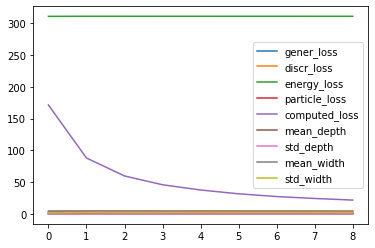

In [36]:
hist = np.load(os.path.join("model_results","history.npy"), allow_pickle=True)
hist = hist.item() # necessary because numpy create a structured dictionary
print(hist)
plt.figure("Evolution of losses per epochs")
for key in hist:
    plt.plot(hist[key], label=key)
plt.legend()
plt.show()

Save to git
===========

In [ ]:
!git status

In [ ]:
!git add ..

In [ ]:
!git commit -m "push from colab"

In [ ]:
!git push